# Human Activity Recognition


## Problem-Statement
Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories(multi-class classification).

**Six-Categories:**
 
* WALKING,
* WALKING_UPSTAIRS,
* WALKING_DOWNSTAIRS,
* SITTING,
* STANDING,
* LAYING.


### About Data:
This dataset is collected from 30 persons, performing different activities with a smartphone to their waists. The data is recorded with the help of sensors (accelerometer and Gyroscope) in that smartphone.

* Accelerometer readings are divided into total acceleration and body acceleration readings, which has x,y and z components each.
* Gyroscope readings are the measure of angular velocities which has x,y and z components.
* Pre-processing accelerometer and gyroscope readings using noise filters.
* Splitting data into fixed windows of 2.56 seconds (128 data points) with 50% overlap.Splitting of accelerometer data into gravitational (total) and body motion components


## Train and Test Split

* The dataset was split into train (70%) and test (30%) sets based on data for subjects, e.g. 21 Persons data for train and 9 persons data for test.
* Each data-point corresponds to one of the six-activities
* 7352 train and 2947 test samples


### Note
* There are three main signal types in the raw data: total acceleration, body acceleration, and body gyroscope. Each has 3 axises of data. This means that there are a total of nine variables for each time step.

* one row of data has (128 * 9), or 1,152 elements.


###  class_labels
+ In the dataset, class_labels are represented as numbers from 1 to 6 as their identifiers.

	- WALKING as __1__
	- WALKING_UPSTAIRS as __2__
	- WALKING_DOWNSTAIRS as __3__
	- SITTING as __4__
	- STANDING as __5__
	- LAYING as __6__

In [31]:
#Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from prettytable import PrettyTable
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
from keras.optimizers import Adam,RMSprop,SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### Importing Data

In [32]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

#Tri-axial readings of body acceleration and body acceleration measured 
 #by accelerometer and angular velocity measured by gyroscope
SIGNALS = ["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x","body_gyro_y","body_gyro_z","total_acc_x","total_acc_y",
           "total_acc_z"]

In [33]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).as_matrix()) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [34]:
#utility function fot one-hot encoding for class-labels
def load_y(subset):
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).as_matrix()

In [35]:
#utility function for labeling back
def load_class(subset):
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return y

In [36]:
#obtaining data from multiple files for train and test
def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

## Train-Test Data

In [37]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Gangadhar\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [38]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

# Utility function to count the number of data-points in each class
def count_class(y):
    return (set([tuple(category) for category in y]))

In [39]:
#getting the number of timesteps , input-dimesion and total number of data-points in x_train
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print("Total number Train-Data-points {}:".format(len(X_train)))
print("Total number Test-Data-points {}:".format(len(X_test)) )     
print("Number of timesteps {}:" .format(timesteps)) #Need to be 128 as we divided each window as 128 timesteps
print("Size of reading at each time-step {}:".format(input_dim)) #at each time step we have taken 3-axial readings of total,body and gyro
print("Number of classes {}:" .format(n_classes)) #has to be 6 as we 6 types of activities

Total number Train-Data-points 7352:
Total number Test-Data-points 2947:
Number of timesteps 128:
Size of reading at each time-step 9:
Number of classes 6:


In [40]:
#checking class-labels after one-hot encoding
print(Y_train[0:5])

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


In [41]:
#labelling back
y_train_class, y_test_class = load_class('train'), load_class('test')
label_dict = {1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS',4: 'SITTING',5: 'STANDING', 6: 'LAYING'}
y_class_final = [label_dict[item] for item in y_train_class] 
Y_test_final =[label_dict[item] for item in y_test_class]

## Check For Data Balance

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
dtype: int64


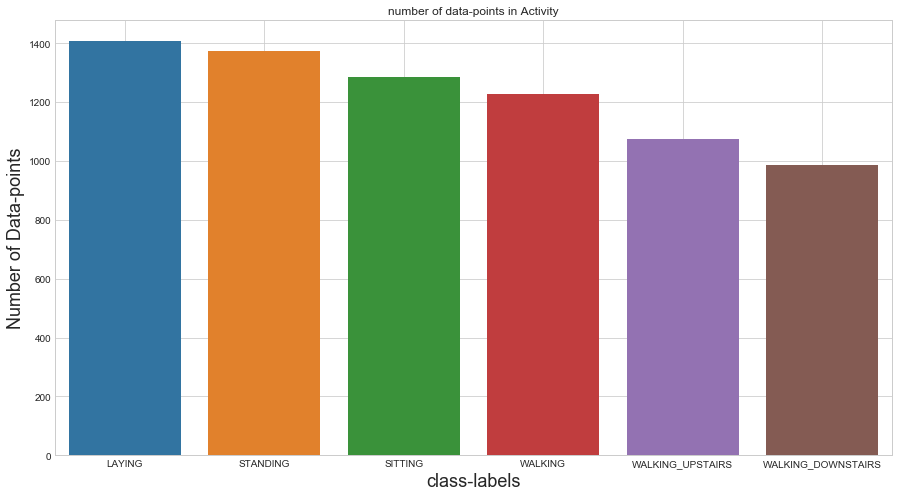

In [42]:
#checking the whether data set is balanced or not
#getting the number of data-poins presernt in each category
activity_count = pd.Series(y_class_final).value_counts()
print(activity_count)

#ploting the number of reviews in each category
plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.barplot(activity_count.index , activity_count.values)
plt.title("number of data-points in Activity")
plt.ylabel('Number of Data-points', fontsize=18)
plt.xlabel('class-labels', fontsize=18 ) 
plt.grid(True)
plt.show()


# Simple LSTM for Activity Classification

In [43]:
#initializing parameters
n_timesteps  = X_train.shape[1] #128 timesteps basically
n_outputs = Y_train.shape[1]  #6 outputs as we have 6-label classification
n_features =X_train.shape[2] #9 readings at each timestep

print("Number of timesteps :{}".format(n_timesteps))
print("Number of Outputs :{}".format(n_outputs))
print("Number of Features of each timestep :{}".format(n_features))

Number of timesteps :128
Number of Outputs :6
Number of Features of each timestep :9


In [49]:
n_hidden =32
batch_size =64
epochs = 30
drop_out = 0.5

# fix random seed for reproducibility
seed = 329
np.random.seed(seed)

#Initiliazing the sequential model
model = Sequential()
#Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(n_timesteps, n_features)))
#Adding a dropout layer
model.add(Dropout(drop_out))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_outputs, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 32)                5376      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compiling the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Training the model
history=model.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 6s 797us/step - loss: 1.4576 - acc: 0.3875 - val_loss: 1.2687 - val_acc: 0.4516
Epoch 2/30
7352/7352 [==============================] - 5s 616us/step - loss: 1.1392 - acc: 0.4917 - val_loss: 1.1496 - val_acc: 0.4903
Epoch 3/30
7352/7352 [==============================] - 5s 622us/step - loss: 1.0680 - acc: 0.5332 - val_loss: 1.0240 - val_acc: 0.5677
Epoch 4/30
7352/7352 [==============================] - 4s 609us/step - loss: 0.9285 - acc: 0.6045 - val_loss: 0.8696 - val_acc: 0.6379
Epoch 5/30
7352/7352 [==============================] - 4s 609us/step - loss: 0.7535 - acc: 0.6804 - val_loss: 0.8041 - val_acc: 0.6240
Epoch 6/30
7352/7352 [==============================] - 5s 622us/step - loss: 0.7072 - acc: 0.6858 - val_loss: 0.7459 - val_acc: 0.7089
Epoch 7/30
7352/7352 [==============================] - 4s 609us/step - loss: 0.6456 - acc: 0.7163 - val_loss: 0.6782 - val_acc: 0.7374


In [51]:
#lists for appending the results of each model
train_loss_list =[];
test_loss_list =[];
train_accuracy_list =[];
test_accuracy_list = []

##evaluating on test-data
[test_loss, test_acc] = model.evaluate(X_test, Y_test)
[train_loss, train_acc] = model.evaluate(X_train, Y_train)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}%".format(test_loss, test_acc*100))
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)
train_accuracy_list.append(train_acc)
test_accuracy_list.append(test_acc)

7352/7352 [==============================] - 1s 169us/step
Evaluation result on Test Data : Loss = 0.48337945974056495, accuracy = 87.51272480488632%


Text(0.5,1,'Categorical-CrossEntropy Curves')

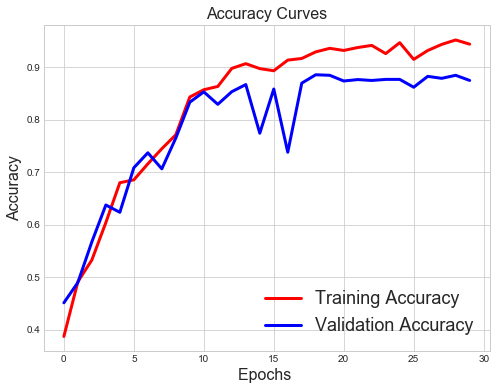

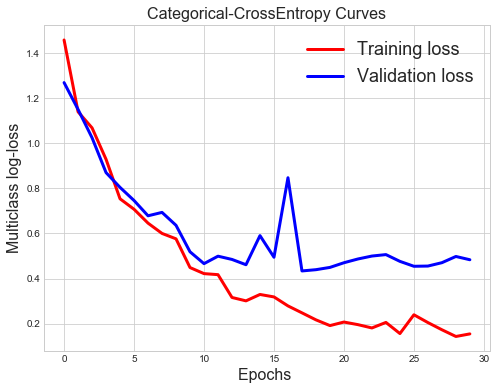

In [52]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#Plot the loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Multiclass log-loss',fontsize=16)
plt.title('Categorical-CrossEntropy Curves',fontsize=16)

In [53]:
#index numbers of activities in one-hot encodeing
ACTIVITIES1 = {0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS',3: 'SITTING',4: 'STANDING', 5: 'LAYING'}
# Utility function to get the predicted labels from probabilities
def confusion_labels(Y_t, Y_p):
    Y_true = pd.Series([ACTIVITIES1[y] for y in np.argmax(Y_t, axis=1)])
    Y_pred = pd.Series([ACTIVITIES1[y] for y in np.argmax(Y_p, axis=1)])
    return Y_true ,Y_pred

In [54]:
#getting the label names of test and predicted values 
Y_true ,Y_pred = (confusion_labels(Y_test, model.predict(X_test)))

In [55]:
# This function plots the confusion matrix.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(18,10))
    labels = [ 'WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
    # representing A in heatmap format
    cmap=sns.light_palette("red")
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    plt.show()

+------------------+----------------+
| metric/parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    optimizer     |      Adam      |
|     Dropout      |      0.5       |
|  Train-logloss   |      0.13      |
|   Test-logloss   |      0.48      |
|  Train-accuracy  |     95.24      |
|  Test-accuracy   |     87.51      |
+------------------+----------------+


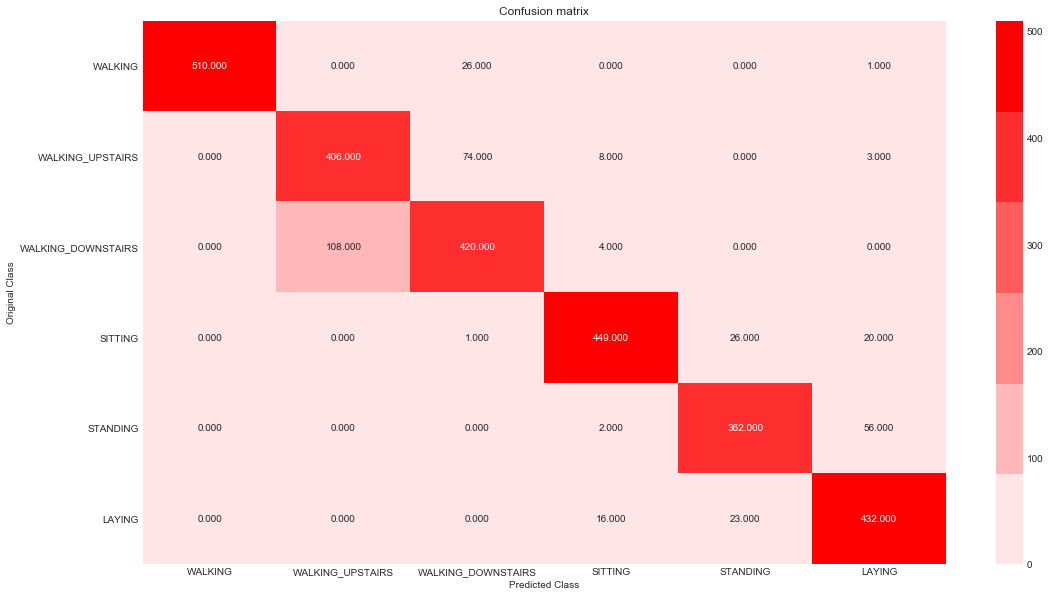

In [56]:
#reporting the results in a table
order_list = [0]

from prettytable import PrettyTable
for i in order_list:
  t= PrettyTable()
  t.field_names =["metric/parameter" , "result"]
  t.add_row (["Model" ,"Classification"])
  t.add_row(["optimizer","Adam"])
  t.add_row(["Dropout",0.5])
  t.add_row (["Train-logloss" ,round(train_loss_list[i],2)])
  t.add_row (["Test-logloss" ,round(test_loss_list[i],2)])
  t.add_row(["Train-accuracy",round(train_accuracy_list[i]*100,2)])
  t.add_row(["Test-accuracy",round(test_accuracy_list[i]*100,2)])
  print(t)
    
plot_confusion_matrix(Y_true,Y_pred)    

### Observations :
    * we choose hyperparameters like drop-out,numbers of LSTM-UNITS and number of LSTM layers randomly and got accuracy close to 88%. Further we need to tune the hyperparameters to improve the model accuracy
    * Activities like Walking,sitting,standing,laying got predicted well with this model as we can see from the confusion  matrix.
    *walking down-stairs and Walking upstairs has got poor prediction and interesting thing is that their incorrect predictions are just between these two activities ,which can be possible as both activities have similar motion
    * sitting and laying has got some what poor predictions,most of the incorrect prediction of those classes are between those two classes only

## Tuning Hyperparameters using GridSerach of Scikit-learn

In [47]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#utility function for getting the best parameters
def best_hyperparameters(n_units,dropout_rate):
    #Initiliazing the sequential model
    model = Sequential()
    #Configuring the parameters
    model.add(LSTM(n_units, input_shape=(n_timesteps, n_features)))
    #Adding a dropout layer
    model.add(Dropout(dropout_rate))
    # Adding a dense output layer with softmax activation
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= "adam")
    return model


#hyperparameters which are to be tuned
n_units = [8,16,32,64,128,256]
dr = [ 0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

#dictionary for parameters used in gridsearch
param_grid = dict(n_units =n_units,dropout_rate=dr)
#using kerasclassifier
model1 = KerasClassifier(build_fn=best_hyperparameters, verbose=0,epochs = 30 ,batch_size = 64)

#initializing gridsearch
grid = GridSearchCV(estimator=model1, param_grid=param_grid,refit = True,cv=3,n_jobs =-1)
grid_result = grid.fit(X_train, Y_train)

#getting the accuracy with best parameters and best parameters after gridsearch    
print("Best accuracy : %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best accuracy: 0.948585 using {'dropout_rate': 0.2, 'n_units': 128}


In [64]:
n_hidden =128
batch_size =64
epochs = 30
drop_out = 0.2

# fix random seed for reproducibility
seed = 329
np.random.seed(seed)

#Initiliazing the sequential model
model2 = Sequential()
#Configuring the parameters
model2.add(LSTM(n_hidden, input_shape=(n_timesteps, n_features)))
#Adding a dropout layer
model2.add(Dropout(drop_out))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_outputs, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 128)               70656     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Compiling the model
model2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Training the model
history2=model2.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 21s 3ms/step - loss: 1.3075 - acc: 0.4595 - val_loss: 1.2141 - val_acc: 0.4961
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.9824 - acc: 0.6058 - val_loss: 0.8464 - val_acc: 0.6464
Epoch 3/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.7223 - acc: 0.7159 - val_loss: 0.6622 - val_acc: 0.7513
Epoch 4/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.4892 - acc: 0.8270 - val_loss: 0.5794 - val_acc: 0.7998
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.3455 - acc: 0.8867 - val_loss: 0.3957 - val_acc: 0.8778
Epoch 6/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.2717 - acc: 0.9100 - val_loss: 0.3216 - val_acc: 0.8802
Epoch 7/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.2724 - acc: 0.9090 - val_loss: 0.8651 - val_acc: 0.7584
Epoch 8

In [66]:
#lists for appending the results of each model
train_loss_list1 =[];
test_loss_list1 =[];
train_accuracy_list1 =[];
test_accuracy_list1 = []

##evaluating on test-data
[test_loss1, test_acc1] = model2.evaluate(X_test, Y_test)
[train_loss1, train_acc1] = model2.evaluate(X_train, Y_train)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}%".format(test_loss1, test_acc1*100))
train_loss_list1.append(train_loss1)
test_loss_list1.append(test_loss1)
train_accuracy_list1.append(train_acc1)
test_accuracy_list1.append(test_acc1)


7352/7352 [==============================] - 4s 547us/step
Evaluation result on Test Data : Loss = 0.24126175699269584, accuracy = 91.61859518154056%


Text(0.5,1,'Categorical-CrossEntropy Curves')

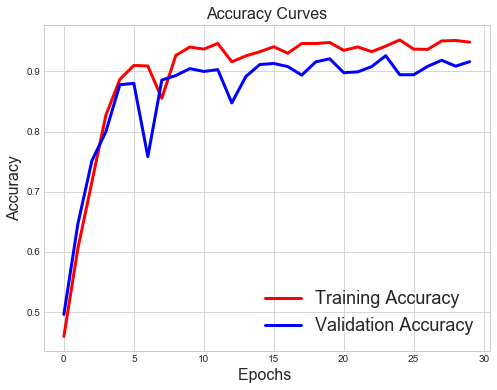

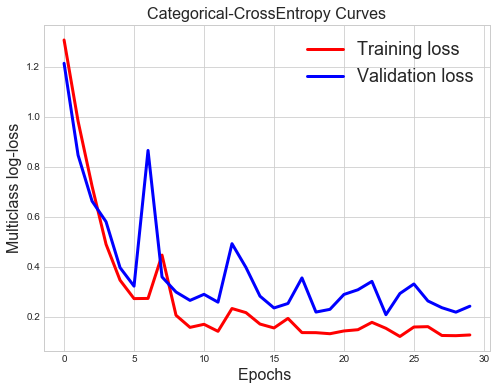

In [67]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['acc'],'r',linewidth=3.0)
plt.plot(history2.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#Plot the loss Curves
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Multiclass log-loss',fontsize=16)
plt.title('Categorical-CrossEntropy Curves',fontsize=16)

+------------------+----------------+
| metric/parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Algorithm     |      LSTM      |
|     Dropout      |      0.2       |
|  Train-logloss   |      0.12      |
|   Test-logloss   |      0.24      |
|  Train-accuracy  |     94.27      |
|  Test-accuracy   |     91.62      |
+------------------+----------------+


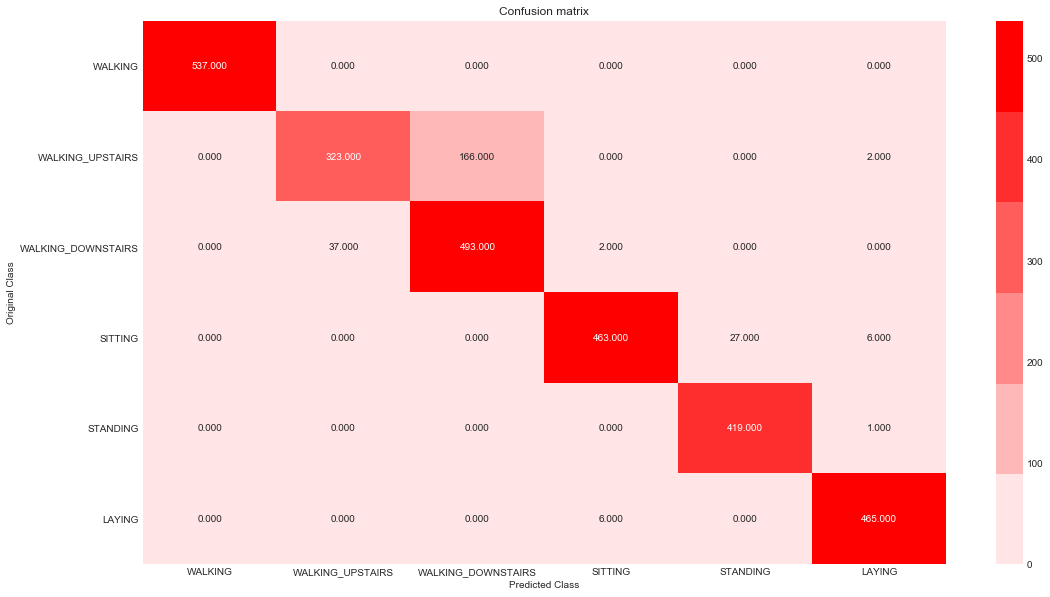

In [68]:
#reporting the results in a table
order_list = [0]

from prettytable import PrettyTable
for i in order_list:
  t= PrettyTable()
  t.field_names =["metric/parameter" , "result"]
  t.add_row (["Model" ,"Classification"])
  t.add_row(["Algorithm","LSTM"])
  t.add_row(["Dropout",0.2])
  t.add_row (["Train-logloss" ,round(train_loss_list1[i],2)])
  t.add_row (["Test-logloss" ,round(test_loss_list1[i],2)])
  t.add_row(["Train-accuracy",round(train_accuracy_list1[i]*100,2)])
  t.add_row(["Test-accuracy",round(test_accuracy_list1[i]*100,2)])
  print(t)
#getting the label names of test and predicted values 
Y_true2 ,Y_pred2 = (confusion_labels(Y_test, model2.predict(X_test)))    
plot_confusion_matrix(Y_true2,Y_pred2)  


### Observations :
    * After hyperparameter tuning , we got accuracy more than 91% which better than the model without tuning(87%).
    * Activities like Walking,sitting,standing,laying got predicted well with this model as we can see from the confusion  matrix.
    *walking down-stairs and Walking upstairs has got poor prediction and interesting thing is that their incorrect predictions are just between these two activities ,which can be possible as both activities have similar motion



## Stacked LSTM Model

In [25]:
n_hidden = 128
batch_size =64
epochs = 30
drop_out = 0.7

# fix random seed for reproducibility
seed = 329
np.random.seed(seed)

#Initiliazing the sequential model
model4 = Sequential()
#Configuring the parameters
model4.add(LSTM(n_hidden,return_sequences =True, input_shape=(n_timesteps, n_features)))
#second lstm layer
model4.add(LSTM(n_hidden))
#Adding a dropout layer
model4.add(Dropout(drop_out))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_outputs, activation='softmax'))
model4.summary()
# Compiling the model
model4.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
# Training the model
history4=model4.fit(X_train,Y_train,batch_size=batch_size,validation_data=(X_test, Y_test),epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 128, 128)          70656     
_________________________________________________________________
lstm_13 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 774       
Total params: 203,014
Trainable params: 203,014
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 55s 8ms/step - loss: 1.1411 - acc: 0.5189 - val_loss: 0.9241 - val_acc: 0.6128
Epoch 2/30
7352/7352 [==============================] - 56s 8ms/step - loss: 0.7101 -

In [27]:
#lists for appending the results of each model
train_loss_list2 =[];
test_loss_list2 =[];
train_accuracy_list2 =[];
test_accuracy_list2 = []

##evaluating on test-data
[test_loss4, test_acc4] = model4.evaluate(X_test, Y_test)
[train_loss4, train_acc4] = model4.evaluate(X_train, Y_train)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}%".format(test_loss4, test_acc4*100))
train_loss_list2.append(train_loss4)
test_loss_list2.append(test_loss4)
train_accuracy_list2.append(train_acc4)
test_accuracy_list2.append(test_acc4)


7352/7352 [==============================] - 8s 1ms/step
Evaluation result on Test Data : Loss = 0.27523007831968554, accuracy = 92.05972175093315%


Text(0.5,1,'Categorical-CrossEntropy Curves')

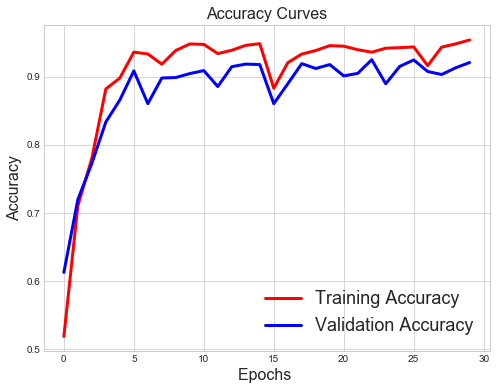

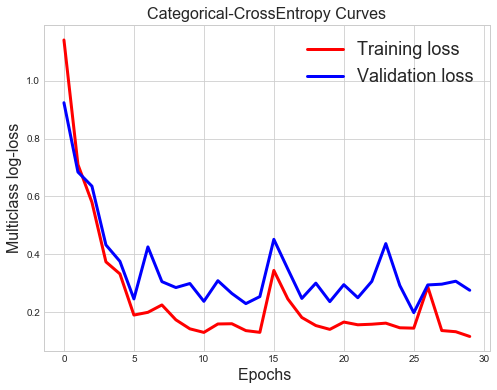

In [28]:
#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['acc'],'r',linewidth=3.0)
plt.plot(history4.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

#Plot the loss Curves
plt.figure(figsize=[8,6])
plt.plot(history4.history['loss'],'r',linewidth=3.0)
plt.plot(history4.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Multiclass log-loss',fontsize=16)
plt.title('Categorical-CrossEntropy Curves',fontsize=16)

+------------------+----------------+
| metric/parameter |     result     |
+------------------+----------------+
|      Model       | Classification |
|    Algorithm     |  Stacked-LSTM  |
|    optimizer     |      Adam      |
|     Dropout      |      0.7       |
|  Train-logloss   |      0.11      |
|   Test-logloss   |      0.28      |
|  Train-accuracy  |      95.8      |
|  Test-accuracy   |     92.06      |
+------------------+----------------+


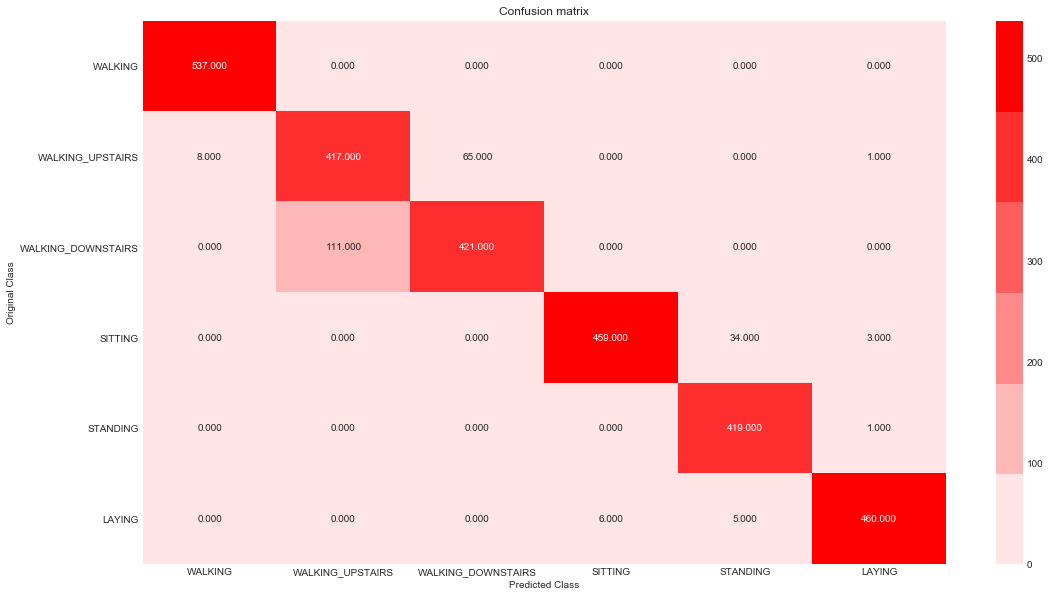

In [30]:
#reporting the results in a table
order_list = [0]

from prettytable import PrettyTable
for i in order_list:
  t= PrettyTable()
  t.field_names =["metric/parameter" , "result"]
  t.add_row (["Model" ,"Classification"])
  t.add_row(["Algorithm","Stacked-LSTM"])
  t.add_row(["optimizer","Adam"])
  t.add_row(["Dropout",0.7])
  t.add_row (["Train-logloss" ,round(train_loss_list2[i],2)])
  t.add_row (["Test-logloss" ,round(test_loss_list2[i],2)])
  t.add_row(["Train-accuracy",round(train_accuracy_list2[i]*100,2)])
  t.add_row(["Test-accuracy",round(test_accuracy_list2[i]*100,2)])
  print(t)
#getting the label names of test and predicted values 
Y_true3 ,Y_pred3 = (confusion_labels(Y_test, model4.predict(X_test)))    
plot_confusion_matrix(Y_true3,Y_pred3)  


### Observations :
    * After using stacked-lstm, we got accuracy more than 92%.
    * Activities like Walking,sitting,standing,laying got predicted well with this model as we can see from the confusion  matrix.
    *walking down-stairs and Walking upstairs has got poor prediction and interesting thing is that their incorrect predictions are just between these two activities ,which can be possible as both activities have similar motion